In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

%matplotlib inline

In [2]:
black = 'k'
softblack = 'k'
gray = '0.75'

mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05)

In [3]:
text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=black, lw=0.8)

In [4]:
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']]
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]
light_colors = [cmap(0.25) for cmap in cmaps]

edgewidth = 0.6

In [5]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

In [6]:
df.head()

,kf,n,Kin,MBPT_HF,MBPT_2,MBPT_3,MBPT_4,Lambda,OrderEFT,Body,x,fit
0,1.13972,0.05,16.16071,10.59411,8.65878,8.67497,8.64329,450,LO,NN-only,0.0,NaN
1,1.21113,0.06,18.24937,11.71829,9.65733,9.76082,9.71811,450,LO,NN-only,0.0,NaN
2,1.27499,0.07,20.22456,12.75249,10.60749,10.78706,10.73255,450,LO,NN-only,0.0,NaN
3,1.33302,0.08,22.10753,13.71538,11.52053,11.76357,11.68942,450,LO,NN-only,0.0,NaN
4,1.38640,0.09,23.91344,14.62031,12.40140,12.69820,12.60394,450,LO,NN-only,0.0,NaN


In [7]:
hbar_c = 197.32  # MeV.fm

def nuclear_density(momentum, degeneracy):
    R"""Computes the density of infinite matter in inverse fermi^3
    
    Parameters
    ----------
    momentum : array
        The fermi momentum in inverse fermi
    degeneracy : int
        The degeneracy factor. Equals 2 for neutron matter and 4 for symmetric matter.
    """
    return degeneracy * momentum**3 / (6 * np.pi**2)

def fermi_momentum(density, degeneracy):
    R"""Computes the fermi momentum of infinite matter in inverse fermi
    
    Parameters
    ----------
    density : array
        The density in inverse fermi^3
    degeneracy : int
        The degeneracy factor. Equals 2 for neutron matter and 4 for symmetric matter.
    """
    return (6 * np.pi**2 * density / degeneracy)**(1./3)

def ratio(momentum, breakdown=600):
    return momentum.ravel() * hbar_c / breakdown

In [8]:
def Lb_prior(Lb):
    return np.where((Lb >= 300) & (Lb <= 1000), 1 / Lb, 0.)

def Lb_logprior(Lb):
    return np.where((Lb >= 300) & (Lb <= 1000), np.log(1 / Lb), -np.inf)

# 3 Body Forces

In [9]:
df.head()

,kf,n,Kin,MBPT_HF,MBPT_2,MBPT_3,MBPT_4,Lambda,OrderEFT,Body,x,fit
0,1.13972,0.05,16.16071,10.59411,8.65878,8.67497,8.64329,450,LO,NN-only,0.0,NaN
1,1.21113,0.06,18.24937,11.71829,9.65733,9.76082,9.71811,450,LO,NN-only,0.0,NaN
2,1.27499,0.07,20.22456,12.75249,10.60749,10.78706,10.73255,450,LO,NN-only,0.0,NaN
3,1.33302,0.08,22.10753,13.71538,11.52053,11.76357,11.68942,450,LO,NN-only,0.0,NaN
4,1.38640,0.09,23.91344,14.62031,12.40140,12.69820,12.60394,450,LO,NN-only,0.0,NaN


In [10]:
def compute_posterior_intervals(model, X, data, orders, max_idx, logprior, Lb):
    model.fit(X, data[:, :max_idx+1], orders=orders[:max_idx+1])
    trunc_kernel_theta = model.coeffs_process.kernel_.theta
    log_like = np.array([model.log_marginal_likelihood(trunc_kernel_theta, breakdown=lb) for lb in Lb])
    log_like += logprior
    posterior = np.exp(log_like - np.max(log_like))
    posterior /= np.trapz(posterior, x=Lb)  # Normalize

    bounds = np.zeros((2, 2))
    for i, p in enumerate([0.68, 0.95]):
        bounds[i] = gm.hpd_pdf(pdf=posterior, alpha=p, x=Lb, disp=False)
        
    median = gm.median_pdf(pdf=posterior, x=Lb)
    return posterior, bounds, median


def draw_summary_statistics(bounds68, bounds95, median, height=0, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(bounds68, [height, height], c=darkgray, lw=6, solid_capstyle='round')
    ax.plot(bounds95, [height, height], c=darkgray, lw=2, solid_capstyle='round')
    ax.plot([median], [height], c='white', marker='o', zorder=10, markersize=3)

In [11]:
orders = np.array([0, 2, 3, 4])
body = 'NN-only'
# body = 'NN+3N'
Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train1 = slice(None, None, 5)
# valid1 = slice(2, None, 5)

savefigs = True

Lb = 600
Lb_vals = np.linspace(100, 1000, 200)
Lb_logprior_vals = Lb_logprior(Lb_vals)

kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
    WhiteKernel(noise_level=1e-10, noise_level_bounds='fixed')
ref1 = 16


mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

mask1 = \
    (df['Body'] == body) & \
    mask_fit & \
    (df['Lambda'] == Lambda)


# df_fit = df[mask_fit]
df_n = df[mask1 & (df['x'] == 0)]
df_s = df[mask1 & (df['x'] == 0.5)]

kf_n = df_n[df_n['OrderEFT'] == 'LO']['kf'].values
kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values
density = df_n[df_n['OrderEFT'] == 'LO']['n'].values
kf_d = kf_n.copy()

valid1 = np.arange(len(kf_n)) % 5 == 0

Kf_n = kf_n[:, None]
Kf_s = kf_s[:, None]
Kf_d = kf_d[:, None]

y1_n = np.array([df_n[df_n['OrderEFT'] == order]['MBPT_4'].values for order in np.unique(df_n['OrderEFT'])]).T
y1_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in np.unique(df_s['OrderEFT'])]).T
y1_d = y1_s - y1_n

c1_n = gm.coefficients(y1_n, ratio(kf_n, Lb), ref=ref1, orders=orders)
c1_s = gm.coefficients(y1_s, ratio(kf_s, Lb), ref=ref1, orders=orders)
c1_d = gm.coefficients(y1_d, ratio(kf_d, Lb), ref=ref1, orders=orders)

In [12]:
def figure_name(name, body, Lambda, fit_n2lo, fit_n3lo, breakdown, ref):
    if body == 'NN+3N':
        full_name = name + f'_body-{body}_fits-{fit_n2lo}-{fit_n3lo}'
    else:
        full_name = name + f'_body-{body}_fits-0-0'
    full_name += f'_Lambda-{Lambda:.0f}_breakdown-{breakdown:.0f}_ref-{ref:.0f}.pdf'
    return full_name

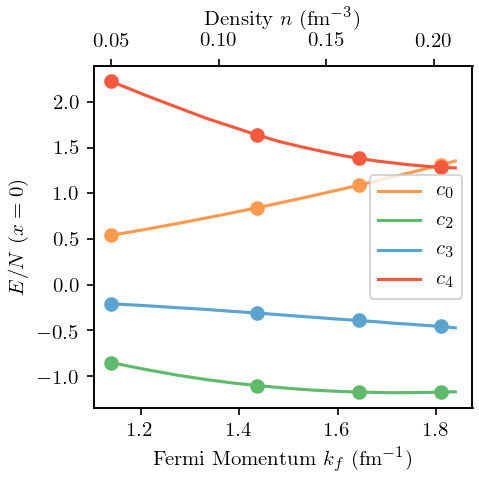

In [13]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax2 = ax.twiny()
for i, n in enumerate(orders):
    ax.plot(kf_n, c1_n[:, i], c=colors[i], label=fr'$c_{{{n}}}$')
    ax.plot(kf_n[train1], c1_n[train1, i], marker='o', ls='', c=colors[i])

ax.legend()
ax2.plot(density, c1_n[:, 0], ls='', c=colors[i])  # Dummy data to set up ticks
ax2.set_xlabel(r'Density $n$ (fm$^{-3}$)')
ax.set_ylabel(r'$E/N$ ($x=0$)')
ax.set_xlabel(r'Fermi Momentum $k_f$ (fm$^{-1}$)')
fig.tight_layout();
if savefigs:
    fig.savefig(figure_name(
        'figures/coeffs_energy_per_particle_neutron', body=body, Lambda=Lambda, fit_n2lo=fits[Lambda][0],
        fit_n3lo=fits[Lambda][1], breakdown=Lb, ref=ref1
    ))

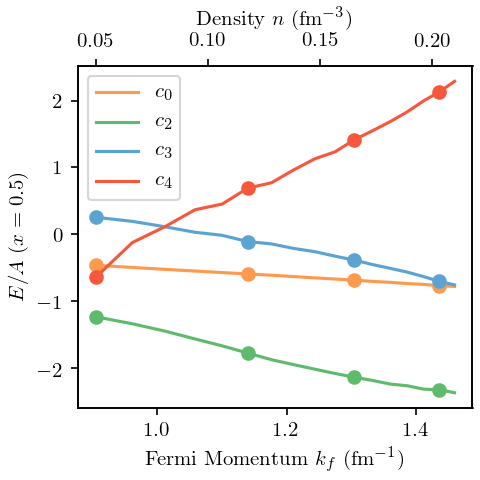

In [14]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax2 = ax.twiny()
for i, n in enumerate(orders):
    ax.plot(kf_s, c1_s[:, i], c=colors[i], label=fr'$c_{{{n}}}$')
    ax.plot(kf_s[train1], c1_s[train1, i], marker='o', ls='', c=colors[i])

ax.legend()
ax2.plot(density, c1_s[:, 0], ls='', c=colors[i])  # Dummy data to set up ticks
ax2.set_xlabel(r'Density $n$ (fm$^{-3}$)')
ax.set_ylabel(r'$E/A$ ($x=0.5$)')
ax.set_xlabel(r'Fermi Momentum $k_f$ (fm$^{-1}$)')
fig.tight_layout();
if savefigs:
    fig.savefig(figure_name(
        'figures/coeffs_energy_per_particle_symmetric', body=body, Lambda=Lambda, fit_n2lo=fits[Lambda][0],
        fit_n3lo=fits[Lambda][1], breakdown=Lb, ref=ref1
    ))

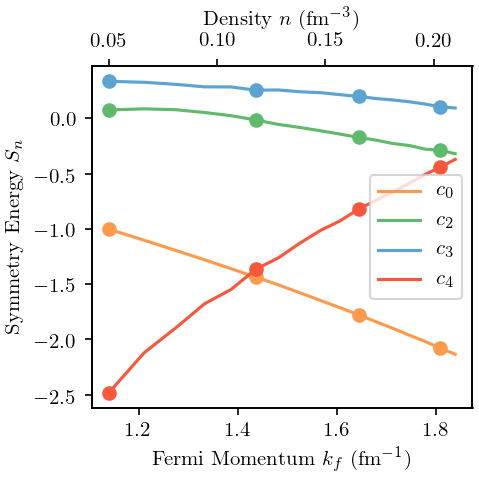

In [15]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))
ax2 = ax.twiny()
for i, n in enumerate(orders):
    ax.plot(kf_d, c1_d[:, i], c=colors[i], label=fr'$c_{{{n}}}$')
    ax.plot(kf_d[train1], c1_d[train1, i], marker='o', ls='', c=colors[i])

ax.legend()
ax2.plot(density, c1_d[:, 0], ls='', c=colors[i])  # Dummy data to set up ticks
ax2.set_xlabel(r'Density $n$ (fm$^{-3}$)')
ax.set_ylabel(r'Symmetry Energy $S_n$')
ax.set_xlabel(r'Fermi Momentum $k_f$ (fm$^{-1}$)')
fig.tight_layout();
if savefigs:
    fig.savefig(figure_name(
        'figures/coeffs_symmetry_energy', body=body, Lambda=Lambda, fit_n2lo=fits[Lambda][0],
        fit_n3lo=fits[Lambda][1], breakdown=Lb, ref=ref1
    ))

We need to check how everything here depends on our priors!
Should adjust `center`, `disp`, `df` and `scale` and see how results change.

In [16]:
gp_trunc1 = gm.TruncationGP(kernel1, ratio=ratio, ref=ref1, excluded=[1], disp=0
                           )

result_n3 = compute_posterior_intervals(
    gp_trunc1, kf_n[train1, None], y1_n[train1], orders=orders,
    max_idx=2, logprior=Lb_logprior_vals, Lb=Lb_vals)
result_n4 = compute_posterior_intervals(
    gp_trunc1, kf_n[train1, None], y1_n[train1], orders=orders,
    max_idx=3, logprior=Lb_logprior_vals, Lb=Lb_vals)


result_s3 = compute_posterior_intervals(
    gp_trunc1, kf_s[train1, None], y1_s[train1], orders=orders,
    max_idx=2, logprior=Lb_logprior_vals, Lb=Lb_vals)
result_s4 = compute_posterior_intervals(
    gp_trunc1, kf_s[train1, None], y1_s[train1], orders=orders,
    max_idx=3, logprior=Lb_logprior_vals, Lb=Lb_vals)

result_d3 = compute_posterior_intervals(
    gp_trunc1, kf_d[train1, None], y1_d[train1], orders=orders,
    max_idx=2, logprior=Lb_logprior_vals, Lb=Lb_vals)
result_d4 = compute_posterior_intervals(
    gp_trunc1, kf_d[train1, None], y1_d[train1], orders=orders,
    max_idx=3, logprior=Lb_logprior_vals, Lb=Lb_vals)

results = [result_n3, result_n4, result_s3, result_s4, result_d3, result_d4]

In [17]:
Lb_colors = light_colors[2:]

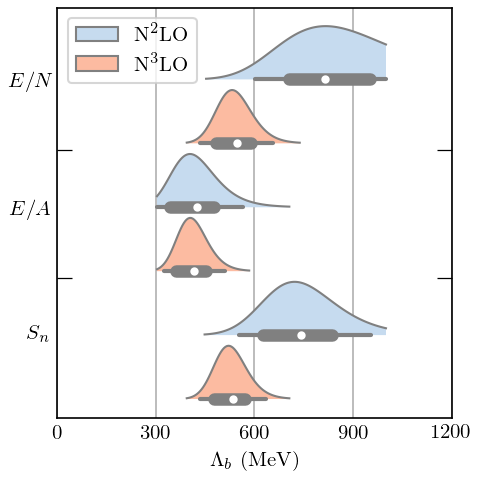

In [18]:
darkgray = '0.5'

fig, ax = plt.subplots(1, 1, figsize=(3.4, 3.4))
for i, (posterior, bounds, median) in enumerate(results):
    posterior = posterior / (1.2*np.max(posterior))  # Scale so they're all the same height
    # Make the lines taper off
    vals = Lb_vals[posterior > 1e-2]
    posterior = posterior[posterior > 1e-2]
    # Plot and fill posterior, and add summary statistics
    ax.plot(vals, posterior-i, c=darkgray, lw=1)
    ax.fill_between(vals, -i, posterior-i, facecolor=Lb_colors[i % 2])
    draw_summary_statistics(*bounds, median, ax=ax, height=-i)

# Plot formatting
ax.set_yticks([-0, -2, -4])
ax.set_yticks([-1.1, -3.1], minor=True)
ax.set_yticklabels([r'$E/N$', r'$E/A$', r'$S_n$'],
                   # fontdict=dict(horizontalalignment='right')
                  )
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(which='major', length=0)
ax.tick_params(which='minor', length=7, right=True)
ax.set_xlim(0, 1200)
ax.set_xticks([0, 300, 600, 900, 1200])
ax.set_xlabel(r'$\Lambda_b$ (MeV)')
ax.grid(axis='x')
ax.set_axisbelow(True)

legend_elements = [
    Patch(facecolor=Lb_colors[0], edgecolor=darkgray, label='N$^2$LO'),
    Patch(facecolor=Lb_colors[1], edgecolor=darkgray, label='N$^3$LO')
]

ax.legend(handles=legend_elements, loc='best')

fig.tight_layout();
if savefigs:
    fig.savefig(figure_name(
        'figures/breakdown_posteriors', body=body, Lambda=Lambda, fit_n2lo=fits[Lambda][0],
        fit_n3lo=fits[Lambda][1], breakdown=Lb, ref=ref1
    ))

In [19]:
def joint_plot(ratio=1, height=3):
    """Taken from Seaborn JointGrid"""
    fig = plt.figure(figsize=(height, height))
    gsp = plt.GridSpec(ratio+1, ratio+1)

    ax_joint = fig.add_subplot(gsp[1:, :-1])
    ax_marg_x = fig.add_subplot(gsp[0, :-1], sharex=ax_joint)
    ax_marg_y = fig.add_subplot(gsp[1:, -1], sharey=ax_joint)

    # Turn off tick visibility for the measure axis on the marginal plots
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Turn off the ticks on the density axis for the marginal plots
    plt.setp(ax_marg_x.yaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_x.yaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_majorticklines(), visible=False)
    plt.setp(ax_marg_y.xaxis.get_minorticklines(), visible=False)
    plt.setp(ax_marg_x.get_yticklabels(), visible=False)
    plt.setp(ax_marg_y.get_xticklabels(), visible=False)
    ax_marg_x.yaxis.grid(False)
    ax_marg_y.xaxis.grid(False)

    # Make the grid look nice
    from seaborn import utils
    # utils.despine(fig)
    utils.despine(ax=ax_marg_x, left=True)
    utils.despine(ax=ax_marg_y, bottom=True)
    fig.tight_layout(h_pad=0, w_pad=0)

    ax_marg_y.tick_params(axis='y', which='major', direction='out')
    ax_marg_x.tick_params(axis='x', which='major', direction='out')
    ax_marg_y.tick_params(axis='y', which='minor', direction='out')
    ax_marg_x.tick_params(axis='x', which='minor', direction='out')
    ax_marg_y.margins(x=0.1, y=0.)

    fig.subplots_adjust(hspace=0, wspace=0)

    return fig, ax_joint, ax_marg_x, ax_marg_y

In [20]:
def compute_2d_likelihood(model, X, data, orders, max_idx, logprior, Lb, ls):
    model.fit(X, data[:, :max_idx+1], orders=orders[:max_idx+1])
    log_like = np.array([
        [model.log_marginal_likelihood(theta=[np.log(ls_),], breakdown=lb) for lb in Lb] for ls_ in ls
    ])
    log_like += logprior
    like = np.exp(log_like - np.max(log_like))
    # like /= np.trapz(like, x=Lb)  # Normalize
    
    ratio_like = np.trapz(like, x=ls, axis=0)
    ls_like = np.trapz(like, x=Lb, axis=-1)

    # Normalize them
    ratio_like /= np.trapz(ratio_like, x=Lb, axis=0)
    ls_like /= np.trapz(ls_like, x=ls, axis=0)
    return like, ratio_like, ls_like

In [21]:
def plot_2d_joint(ls_vals, Lb_vals, like_2d, like_ls, like_Lb, data_str=r'\vec{\mathbf{y}}_k)'):

    with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
        cmap_name = 'Blues'
        cmap = mpl.cm.get_cmap(cmap_name)

        # Setup axes
        fig, ax_joint, ax_marg_x, ax_marg_y = joint_plot(ratio=5, height=3.4)

        # Plot contour
        ax_joint.contour(ls_vals, Lb_vals, like_2d.T,
                         levels=[np.exp(-0.5*r**2) for r in np.arange(9, 0, -0.5)] + [0.999],
                         cmap=cmap_name, vmin=-0.05, vmax=0.8, zorder=1)

        # Now plot the marginal distributions
        ax_marg_y.plot(like_Lb, Lb_vals, c=cmap(0.8), lw=1)
        ax_marg_y.fill_betweenx(Lb_vals, np.zeros_like(like_Lb),
                                like_Lb, facecolor=cmap(0.2), lw=1)
        ax_marg_x.plot(ls_vals, like_ls, c=cmap(0.8), lw=1)
        ax_marg_x.fill_between(ls_vals, np.zeros_like(ls_vals),
                               like_ls, facecolor=cmap(0.2), lw=1)

        # Formatting
        ax_joint.set_xlabel(r'$\ell$')
        ax_joint.set_ylabel(r'$\Lambda_b$')
        ax_joint.margins(x=0, y=0.)
        ax_marg_x.set_ylim(bottom=0);
        ax_marg_y.set_xlim(left=0);
        ax_joint.text(0.95, 0.95, rf'pr$(\ell, \Lambda_b \,|\, {data_str}$)', ha='right', va='top',
                      transform=ax_joint.transAxes,
                      bbox=text_bbox
                     );
        ax_joint.tick_params(direction='in')

        plt.show()
        return fig

In [22]:
ls_vals = np.linspace(0.3, 2.5, 80)
Lb_vals2 = np.linspace(200, 800, 150)

In [23]:
MD_label = r'\mathrm{D}_{\mathrm{MD}}^2'
PC_label = r'\mathrm{D}_{\mathrm{PC}}'

NM_label = r'E/N'
SM_label = r'E/A'
Sn_label = r'S_n'

In [24]:
def offset_xlabel(ax):
    ax.set_xticks([0])
    ax.set_xticklabels(labels=[0], fontdict=dict(color='w'))
    ax.tick_params(axis='x', length=0)
    return ax

## Neutron Matter

In [25]:
like_2d_n, like_Lb_n, like_ls_n = compute_2d_likelihood(
    model=gp_trunc1, X=kf_n[train1, None], data=y1_n[train1], orders=orders, max_idx=3,
    logprior=0, Lb=Lb_vals2, ls=ls_vals
)

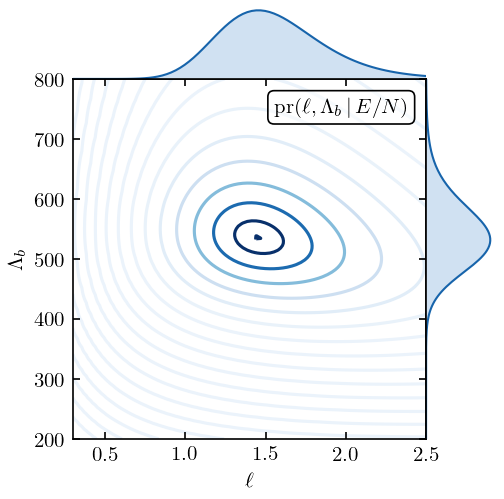

In [26]:
fig = plot_2d_joint(ls_vals=ls_vals, Lb_vals=Lb_vals2, like_2d=like_2d_n, like_ls=like_ls_n,
                    like_Lb=like_Lb_n, data_str=NM_label)
if savefigs:
    fig.savefig(figure_name(
        'figures/joint_posterior_energy_per_particle_neutron', body=body, Lambda=Lambda,
        fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb, ref=ref1
    ))

In [27]:
ls_map_idx_n, Lb_map_idx_n = np.unravel_index(np.argmax(like_2d_n), like_2d_n.shape)
ls_map_n, Lb_map_n = ls_vals[ls_map_idx_n], Lb_vals2[Lb_map_idx_n]
print(ls_map_n, Lb_map_n)

1.4417721518987343 534.2281879194632


In [28]:
nugget_n = 1e-10
kernel_n = RBF(length_scale=ls_map_n) + WhiteKernel(nugget_n)
coeff_gp_n = gm.ConjugateGaussianProcess(kernel=kernel_n, disp=0, optimizer=None)

c1_mapLb_n = gm.coefficients(y1_n, ratio=ratio(kf_n, Lb_map_n), ref=ref1, orders=orders)
coeff_gp_n.fit(Kf_n[train1], c1_mapLb_n[train1]);

In [29]:
coeff_gp_n.kernel_

RBF(length_scale=1.44) + WhiteKernel(noise_level=1e-10)

In [30]:
mean_underlying_n = coeff_gp_n.mean(Kf_n[valid1])
cov_underlying_n = coeff_gp_n.cov(Kf_n[valid1])
gdgn_n = gm.GraphicalDiagnostic(c1_mapLb_n[valid1], mean_underlying_n, cov_underlying_n, colors=colors,
                              gray=gray, black=softblack)

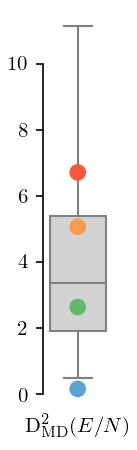

In [31]:
fig, ax = plt.subplots(figsize=(1, 3.2))
ax = gdgn_n.md_squared(type='box', trim=True, title=None, xlabel=rf'${MD_label}({NM_label})$')
# offset_xlabel(ax)
# ax.set_ylim(-0.3, 15)
fig.tight_layout();
fig.savefig(
    figure_name(
            'figures/md_neutron_matter', body=body, Lambda=Lambda,
            fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb_map_n, ref=ref1
        )
)

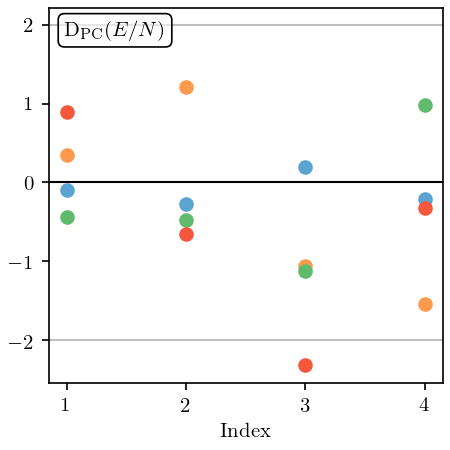

In [32]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gdgn_n.pivoted_cholesky_errors(ax=ax, title=None)
    ax.text(0.04, 0.967, rf'${PC_label}({NM_label})$', bbox=text_bbox,
            transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
    fig.savefig(
        figure_name(
            'figures/pc_neutron_matter', body=body, Lambda=Lambda,
            fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb_map_n, ref=ref1
        )
    )

## Symmetric Matter

In [33]:
like_2d_s, like_Lb_s, like_ls_s = compute_2d_likelihood(
    model=gp_trunc1, X=kf_s[train1, None], data=y1_s[train1], orders=orders, max_idx=3,
    logprior=0, Lb=Lb_vals2, ls=ls_vals
)

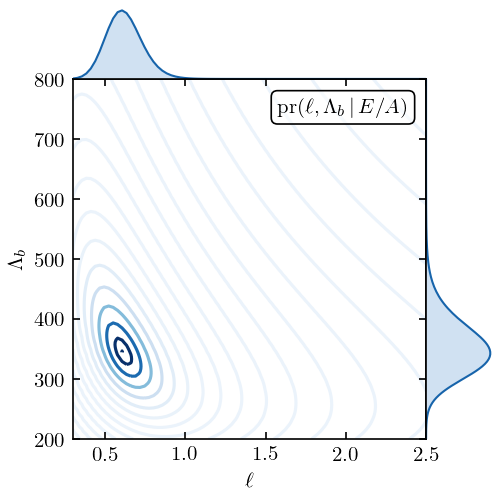

In [34]:
fig = plot_2d_joint(ls_vals=ls_vals, Lb_vals=Lb_vals2, like_2d=like_2d_s, like_ls=like_ls_s,
                    like_Lb=like_Lb_s, data_str=SM_label)
if savefigs:
    fig.savefig(figure_name(
        'figures/joint_posterior_energy_per_particle_symmetric', body=body, Lambda=Lambda,
        fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb, ref=ref1
    ))

In [35]:
ls_map_idx_s, Lb_map_idx_s = np.unravel_index(np.argmax(like_2d_s), like_2d_s.shape)
ls_map_s, Lb_map_s = ls_vals[ls_map_idx_s], Lb_vals2[Lb_map_idx_s]
print(ls_map_s, Lb_map_s)

0.6063291139240506 344.96644295302013


In [36]:
nugget_s = 1e-10
kernel_s = RBF(length_scale=ls_map_s) + WhiteKernel(nugget_s)
coeff_gp_s = gm.ConjugateGaussianProcess(kernel=kernel_s, disp=0, optimizer=None)

c1_mapLb_s = gm.coefficients(y1_s, ratio=ratio(kf_s, Lb_map_s), ref=ref1, orders=orders)
coeff_gp_s.fit(Kf_s[train1], c1_mapLb_s[train1]);

In [37]:
coeff_gp_s.kernel_

RBF(length_scale=0.606) + WhiteKernel(noise_level=1e-10)

In [38]:
mean_underlying_s = coeff_gp_s.mean(Kf_s[valid1])
cov_underlying_s = coeff_gp_s.cov(Kf_s[valid1])
gdgn_s = gm.GraphicalDiagnostic(c1_mapLb_s[valid1], mean_underlying_s, cov_underlying_s, colors=colors,
                              gray=gray, black=softblack)

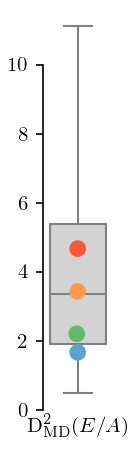

In [39]:
fig, ax = plt.subplots(figsize=(1, 3.2))
ax = gdgn_s.md_squared(type='box', trim=True, title=None, xlabel=rf'${MD_label}({SM_label})$')
# offset_xlabel(ax)
# ax.set_ylim(-0.3, 15)
fig.tight_layout();
fig.savefig(
    figure_name(
            'figures/md_symmetric_matter', body=body, Lambda=Lambda,
            fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb_map_s, ref=ref1
        )
)

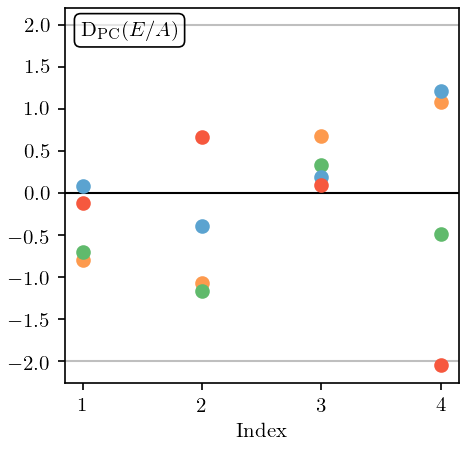

In [40]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gdgn_s.pivoted_cholesky_errors(ax=ax, title=None)
    ax.text(0.04, 0.967, rf'${PC_label}({SM_label})$', bbox=text_bbox,
            transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
    fig.savefig(
        figure_name(
            'figures/pc_symmetric_matter', body=body, Lambda=Lambda,
            fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb_map_n, ref=ref1
        )
    )

## Symmetry Energy

In [41]:
like_2d_d, like_Lb_d, like_ls_d = compute_2d_likelihood(
    model=gp_trunc1, X=kf_d[train1, None], data=y1_d[train1], orders=orders, max_idx=3,
    logprior=0, Lb=Lb_vals2, ls=ls_vals
)

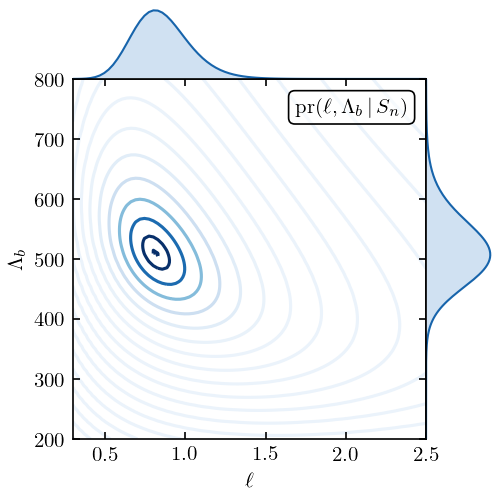

In [42]:
fig = plot_2d_joint(ls_vals=ls_vals, Lb_vals=Lb_vals2, like_2d=like_2d_d, like_ls=like_ls_d,
                    like_Lb=like_Lb_d, data_str=Sn_label)
if savefigs:
    fig.savefig(figure_name(
        'figures/joint_posterior_symmetry_energy', body=body, Lambda=Lambda,
        fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb, ref=ref1
    ))

In [43]:
ls_map_idx_d, Lb_map_idx_d = np.unravel_index(np.argmax(like_2d_d), like_2d_d.shape)
ls_map_d, Lb_map_d = ls_vals[ls_map_idx_d], Lb_vals2[Lb_map_idx_d]
print(ls_map_d, Lb_map_d)

0.8012658227848102 510.0671140939598


In [44]:
nugget_d = 1e-10
kernel_d = RBF(length_scale=ls_map_d) + WhiteKernel(nugget_d)
coeff_gp_d = gm.ConjugateGaussianProcess(kernel=kernel_d, optimizer=None)

c1_mapLb_d = gm.coefficients(y1_d, ratio=ratio(kf_d, Lb_map_d), ref=ref1, orders=orders)
coeff_gp_d.fit(Kf_d[train1], c1_mapLb_d[train1]);

In [45]:
c1_mapLb_d.shape

(17, 4)

In [46]:
coeff_gp_d.kernel_

RBF(length_scale=0.801) + WhiteKernel(noise_level=1e-10)

In [47]:
mean_underlying_d = coeff_gp_d.mean(Kf_d[valid1])
cov_underlying_d = coeff_gp_d.cov(Kf_d[valid1])
gdgn_d = gm.GraphicalDiagnostic(c1_mapLb_d[valid1], mean_underlying_d, cov_underlying_d, colors=colors,
                              gray=gray, black=softblack)

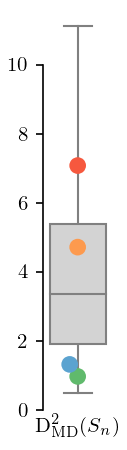

In [48]:
fig, ax = plt.subplots(figsize=(1, 3.2))
ax = gdgn_d.md_squared(type='box', trim=True, title=None, xlabel=rf'${MD_label}({Sn_label})$')
# offset_xlabel(ax)
# ax.set_ylim(0, 15)
fig.tight_layout();
fig.savefig(
    figure_name(
            'figures/md_symmetry_energy', body=body, Lambda=Lambda,
            fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb_map_d, ref=ref1
        )
)

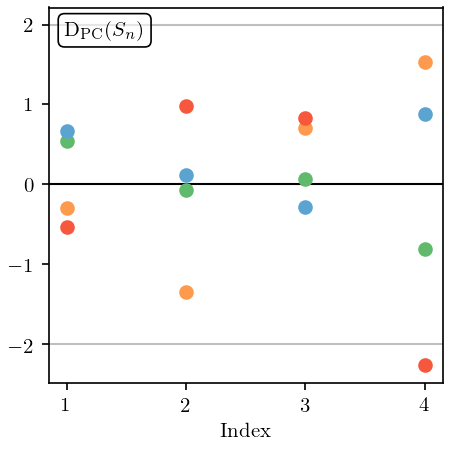

In [49]:
with plt.rc_context({"text.usetex": True, "text.latex.preview": True}):
    fig, ax = plt.subplots(figsize=(3.2, 3.2))
    gdgn_d.pivoted_cholesky_errors(ax=ax, title=None)
    ax.text(0.04, 0.967, rf'${PC_label}({Sn_label})$', bbox=text_bbox, transform=ax.transAxes, va='top', ha='left')
    fig.tight_layout();
    plt.show()
    fig.savefig(
        figure_name(
            'figures/pc_symmetry_energy', body=body, Lambda=Lambda,
            fit_n2lo=fits[Lambda][0], fit_n3lo=fits[Lambda][1], breakdown=Lb_map_d, ref=ref1
        )
    )